In [1]:
import os
import sys
import time
import random
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso

sys.path.append('../src')
import cb_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

In [2]:
# configuration
scoring_run_id = 1
use_cache = True
seed = random.randint(0, 100)
test_set_pct = 0.2
print(f'Seed: {seed}')

Seed: 42


In [3]:
# Load data
# 2018
query = "SELECT * FROM cb.vw_mab_training_data WHERE mab_id = 4;"
mab4 = cb_utils.sql_query_to_df(query, use_cache=use_cache)
mab4.fillna(0, inplace=True)

# 2017
query = "SELECT * FROM cb.vw_mab_training_data WHERE mab_id = 3;"
mab3 = cb_utils.sql_query_to_df(query, use_cache=use_cache)
mab3.fillna(0, inplace=True)

Pulled query from cache
Pulled query from cache


In [14]:
mom_feature_columns = [
#     'lob_at_id'
#   , 'grp_at_id'
    'lob_1_days'
  , 'lob_2_days'
  , 'lob_3_days'
  , 'grp_1_days'
  , 'grp_2_days'
  , 'grp_3_days'
  , 'grp_5_days'
  , 'grp_6_days'
  , 'grp_7_days'
  , 'grp_8_days'
  , 'unaligned_days'
#   , 'is_unaligned'
  , 'tc'
  , 'hcbs_tc'
  , 'icf_tc'
  , 'ip_tc'
  , 'rx_tc'
  , 'ed_tc'
  , 'snf_tc'
  , 'out_tc'
  , 'pro_tc'
  , 'spfac_tc'
  , 'amb_tc'
  , 'hh_tc'
  , 'hosp_tc'
  , 'oth_tc'
  , 'p_mm'
  , 'mm'
  , 'hcbs_respite_tc'
  , 'hcbs_fam_care_stip_tc'
  , 'hcbs_com_trans_tc'
  , 'hcbs_educ_train_tc'
  , 'hcbs_com_liv_fam_tc'
  , 'hcbs_com_liv_tc'
  , 'hcbs_attend_care_tc'
  , 'hcbs_com_trans_waiv_tc'
  , 'hcbs_home_meal_tc'
  , 'hcbs_pers_care_tc'
  , 'hcbs_ther_behav_tc'
  , 'hcbs_unsk_respite_tc'
  , 'hcbs_waiv_svc_tc'
  , 'ddos'
  , 'hcbs_ddos'
  , 'icf_ddos'
  , 'ip_ddos'
  , 'rx_ddos'
  , 'ed_ddos'
  , 'snf_ddos'
  , 'out_ddos'
  , 'pro_ddos'
  , 'spfac_ddos'
  , 'amb_ddos'
  , 'hh_ddos'
  , 'hosp_ddos'
  , 'oth_ddos'
  , 'pcp_ddos'
  , 'chf_ddos'
  , 'heart_ddos'
  , 'copd_ddos'
  , 'pulmonar_ddos'
  , 'cancer_ddos'
  , 'ckd_ddos'
  , 'esrd_ddos'
  , 'hyperlipid_ddos'
  , 'diab_ddos'
  , 'alzh_ddos'
  , 'dementia_ddos'
  , 'stroke_ddos'
  , 'hypertension_ddos'
  , 'fall_ddos'
  , 'transplant_ddos'
  , 'liver_ddos'
  , 'hippfract_ddos'
  , 'depression_ddos'
  , 'psychosis_ddos'
  , 'drug_ddos'
  , 'alcohol_ddos'
  , 'paralysis_ddos'
]
annual_feature_columns = [
#   , 'lvl_ft'
#   , 'is_unaligned_ft'
    'unaligned_mm_ft'
  , 'is_self_directed_ft'
  , 'is_cat0_ft'
  , 'is_cat1_ft'
  , 'is_cat2_ft'
  , 'is_cat3_ft'
  , 'is_cat4_ft'
  , 'is_lob1_ft'
  , 'is_lob2_ft'
  , 'is_lob3_ft'
  , 'is_grp1_ft'
  , 'is_grp2_ft'
  , 'is_grp3_ft'
  , 'is_grp45678_ft'
  , 'sav_pct_ft'
  , 'raf_sav_pct_ft'
  , 'ds_sav_pct_ft'
  , 'ip_sav_pct_ft'
  , 'snf_sav_pct_ft'
  , 'icf_sav_pct_ft'
  , 'ed_sav_pct_ft'
  , 'hh_sav_pct_ft'
  , 'pro_sav_pct_ft'
  , 'out_sav_pct_ft'
  , 'savings_ft'
  , 'raf_savings_ft'
  , 'ds_savings_ft'
  , 'ip_savings_ft'
  , 'snf_savings_ft'
  , 'icf_savings_ft'
  , 'ed_savings_ft'
  , 'hh_savings_ft'
  , 'pro_savings_ft'
  , 'out_savings_ft'
  , 'tc_ft'
  , 'hcbs_atd_pcs_tc_ft'
  , 'ip_tc_ft'
  , 'snf_tc_ft'
  , 'icf_tc_ft'
  , 'ed_tc_ft'
  , 'hh_tc_ft'
  , 'pro_tc_ft'
  , 'out_tc_ft'
  , 'savings_pmpm_ft'
  , 'raf_sav_pmpm_ft'
  , 'ds_sav_pmpm_ft'
  , 'ip_sav_pmpm_ft'
  , 'snf_sav_pmpm_ft'
  , 'icf_sav_pmpm_ft'
  , 'ed_sav_pmpm_ft'
  , 'hh_sav_pmpm_ft'
  , 'pro_sav_pmpm_ft'
  , 'out_sav_pmpm_ft'
  , 'tc_pmpm_ft'
  , 'hcbs_attd_pmpm_ft'
  , 'ip_pmpm_ft'
  , 'snf_pmpm_ft'
  , 'icf_pmpm_ft'
  , 'ed_pmpm_ft'
  , 'hh_pmpm_ft'
  , 'pro_pmpm_ft'
  , 'out_pmpm_ft'
  , 'mm_ft'

]
target_col = 'savings_tgt'
lvl = '2. m'

feature_columns = mom_feature_columns + annual_feature_columns
print(f'N Potential Features: {len(feature_columns)}')

N Potential Features: 140


# Feature selection

xgb
1: alcohol_ddos
1: alzh_ddos
1: amb_ddos
1: amb_tc
1: cancer_ddos
1: chf_ddos
1: copd_ddos
1: ddos
1: dementia_ddos
1: depression_ddos
1: diab_ddos
1: drug_ddos
1: ds_sav_pct_ft
1: ds_sav_pmpm_ft
1: ds_savings_ft
1: ed_ddos
1: ed_sav_pct_ft
1: ed_sav_pmpm_ft
1: ed_savings_ft
1: ed_tc
1: ed_tc_ft
1: esrd_ddos
1: fall_ddos
1: grp_1_days
1: grp_2_days
1: grp_3_days
1: grp_5_days
1: grp_6_days
1: grp_7_days
1: grp_8_days
1: hcbs_atd_pcs_tc_ft
1: hcbs_attd_pmpm_ft
1: hcbs_attend_care_tc
1: hcbs_com_liv_fam_tc
1: hcbs_com_liv_tc
1: hcbs_com_trans_waiv_tc
1: hcbs_ddos
1: hcbs_home_meal_tc
1: hcbs_tc
1: hcbs_ther_behav_tc
1: hcbs_unsk_respite_tc
1: heart_ddos
1: hh_ddos
1: hh_sav_pct_ft
1: hh_sav_pmpm_ft
1: hh_savings_ft
1: hh_tc
1: hh_tc_ft
1: hosp_ddos
1: hyperlipid_ddos
1: hypertension_ddos
1: icf_ddos
1: icf_sav_pct_ft
1: icf_sav_pmpm_ft
1: icf_savings_ft
1: icf_tc
1: icf_tc_ft
1: ip_ddos
1: ip_pmpm_ft
1: ip_sav_pct_ft
1: ip_sav_pmpm_ft
1: ip_savings_ft
1: ip_tc
1: ip_tc_ft
1: is_cat3_

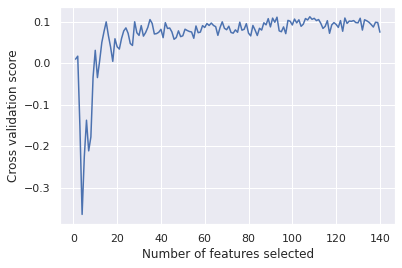

xgb max depth 1
1: alzh_ddos
1: amb_ddos
1: amb_tc
1: cancer_ddos
1: chf_ddos
1: ckd_ddos
1: copd_ddos
1: ddos
1: dementia_ddos
1: depression_ddos
1: diab_ddos
1: ds_sav_pct_ft
1: ds_sav_pmpm_ft
1: ds_savings_ft
1: ed_ddos
1: ed_pmpm_ft
1: ed_sav_pct_ft
1: ed_sav_pmpm_ft
1: ed_savings_ft
1: ed_tc
1: ed_tc_ft
1: esrd_ddos
1: fall_ddos
1: hcbs_atd_pcs_tc_ft
1: hcbs_attd_pmpm_ft
1: hcbs_attend_care_tc
1: hcbs_com_liv_fam_tc
1: hcbs_com_liv_tc
1: hcbs_com_trans_tc
1: hcbs_com_trans_waiv_tc
1: hcbs_ddos
1: hcbs_educ_train_tc
1: hcbs_fam_care_stip_tc
1: hcbs_home_meal_tc
1: hcbs_pers_care_tc
1: hcbs_respite_tc
1: hcbs_tc
1: hcbs_ther_behav_tc
1: hcbs_unsk_respite_tc
1: hcbs_waiv_svc_tc
1: heart_ddos
1: hh_ddos
1: hh_pmpm_ft
1: hh_sav_pct_ft
1: hh_sav_pmpm_ft
1: hh_savings_ft
1: hh_tc
1: hh_tc_ft
1: hippfract_ddos
1: hosp_ddos
1: hosp_tc
1: hyperlipid_ddos
1: hypertension_ddos
1: icf_ddos
1: icf_pmpm_ft
1: icf_sav_pct_ft
1: icf_sav_pmpm_ft
1: icf_savings_ft
1: icf_tc
1: icf_tc_ft
1: ip_ddos
1

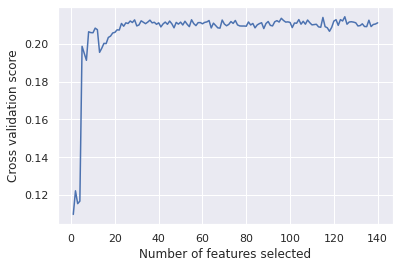

ridge
1: alcohol_ddos
1: alzh_ddos
1: amb_ddos
1: amb_tc
1: cancer_ddos
1: chf_ddos
1: ckd_ddos
1: copd_ddos
1: ddos
1: dementia_ddos
1: depression_ddos
1: diab_ddos
1: drug_ddos
1: ds_sav_pct_ft
1: ds_sav_pmpm_ft
1: ds_savings_ft
1: ed_ddos
1: ed_pmpm_ft
1: ed_sav_pct_ft
1: ed_sav_pmpm_ft
1: ed_savings_ft
1: ed_tc
1: esrd_ddos
1: fall_ddos
1: grp_1_days
1: grp_2_days
1: grp_3_days
1: hcbs_attd_pmpm_ft
1: hcbs_attend_care_tc
1: hcbs_com_liv_fam_tc
1: hcbs_com_trans_waiv_tc
1: hcbs_ddos
1: hcbs_home_meal_tc
1: hcbs_pers_care_tc
1: hcbs_tc
1: hcbs_unsk_respite_tc
1: heart_ddos
1: hh_ddos
1: hh_pmpm_ft
1: hh_sav_pct_ft
1: hh_sav_pmpm_ft
1: hh_savings_ft
1: hh_tc
1: hh_tc_ft
1: hippfract_ddos
1: hosp_ddos
1: hosp_tc
1: hyperlipid_ddos
1: hypertension_ddos
1: icf_ddos
1: icf_pmpm_ft
1: icf_sav_pct_ft
1: icf_sav_pmpm_ft
1: icf_savings_ft
1: icf_tc
1: ip_ddos
1: ip_sav_pct_ft
1: ip_sav_pmpm_ft
1: ip_savings_ft
1: is_cat0_ft
1: is_cat1_ft
1: is_cat2_ft
1: is_cat3_ft
1: is_cat4_ft
1: is_grp1_ft

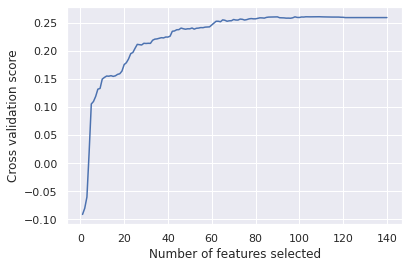

lasso
1: alzh_ddos
1: cancer_ddos
1: ckd_ddos
1: dementia_ddos
1: ds_sav_pmpm_ft
1: ed_savings_ft
1: grp_1_days
1: hcbs_com_trans_waiv_tc
1: hcbs_ddos
1: hcbs_home_meal_tc
1: hcbs_tc
1: heart_ddos
1: hh_savings_ft
1: hypertension_ddos
1: ip_sav_pct_ft
1: is_cat0_ft
1: is_cat3_ft
1: is_cat4_ft
1: is_grp1_ft
1: is_grp2_ft
1: is_lob2_ft
1: is_lob3_ft
1: mm_ft
1: out_sav_pct_ft
1: pcp_ddos
1: pro_ddos
1: pro_sav_pmpm_ft
1: pro_savings_ft
1: psychosis_ddos
1: pulmonar_ddos
1: rx_ddos
1: sav_pct_ft
1: savings_ft
1: snf_ddos
1: snf_sav_pct_ft
1: snf_savings_ft
1: stroke_ddos
1: unaligned_mm_ft
2: is_self_directed_ft
3: hcbs_attend_care_tc
4: amb_tc
5: ds_savings_ft
6: icf_tc_ft
7: p_mm
8: unaligned_days
9: grp_8_days
10: grp_7_days
11: grp_6_days
12: grp_5_days
13: grp_3_days
14: grp_2_days
15: tc
16: copd_ddos
17: snf_tc
18: icf_tc
19: savings_pmpm_ft
20: ip_tc
21: rx_tc
22: alcohol_ddos
23: ed_tc
24: drug_ddos
25: raf_sav_pmpm_ft
26: hosp_tc
27: spfac_tc
28: hh_tc
29: out_pmpm_ft
30: paraly

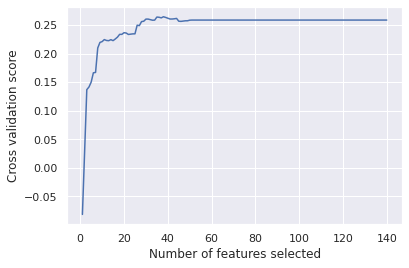

rf
1: alcohol_ddos
1: alzh_ddos
1: amb_ddos
1: amb_tc
1: cancer_ddos
1: chf_ddos
1: ckd_ddos
1: copd_ddos
1: ddos
1: dementia_ddos
1: depression_ddos
1: diab_ddos
1: drug_ddos
1: ds_sav_pct_ft
1: ds_sav_pmpm_ft
1: ds_savings_ft
1: ed_ddos
1: ed_pmpm_ft
1: ed_sav_pct_ft
1: ed_sav_pmpm_ft
1: ed_savings_ft
1: ed_tc
1: ed_tc_ft
1: esrd_ddos
1: fall_ddos
1: grp_1_days
1: grp_2_days
1: grp_3_days
1: grp_5_days
1: grp_6_days
1: grp_7_days
1: grp_8_days
1: hcbs_atd_pcs_tc_ft
1: hcbs_attd_pmpm_ft
1: hcbs_attend_care_tc
1: hcbs_com_liv_fam_tc
1: hcbs_com_liv_tc
1: hcbs_com_trans_tc
1: hcbs_com_trans_waiv_tc
1: hcbs_ddos
1: hcbs_fam_care_stip_tc
1: hcbs_home_meal_tc
1: hcbs_pers_care_tc
1: hcbs_respite_tc
1: hcbs_tc
1: hcbs_ther_behav_tc
1: hcbs_unsk_respite_tc
1: hcbs_waiv_svc_tc
1: heart_ddos
1: hh_ddos
1: hh_pmpm_ft
1: hh_sav_pct_ft
1: hh_sav_pmpm_ft
1: hh_savings_ft
1: hh_tc
1: hh_tc_ft
1: hippfract_ddos
1: hosp_ddos
1: hosp_tc
1: hyperlipid_ddos
1: hypertension_ddos
1: icf_ddos
1: icf_pmpm_f

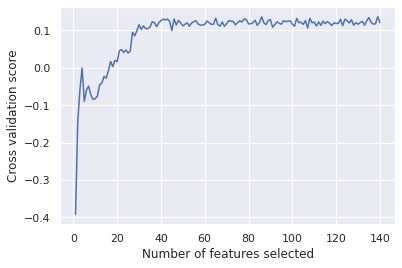

In [15]:
from sklearn.feature_selection import RFECV

df = mab4.loc[mab4.lvl_tgt == lvl]

targets_df = df[['member_id', target_col]].groupby('member_id').first()

features_df = cb_utils.features_annual(df, mom_feature_columns)
pre_annual = df.query("period < 0")[annual_feature_columns + ['member_id']].groupby('member_id').first()

features_df = features_df.merge(pre_annual, left_index=True, right_index=True)
features_df.fillna(0, inplace=True)

# order features and targets by member id, make sure they line up perfectly
features_df.sort_index(inplace=True)
targets_df.sort_index(inplace=True)
assert sum(targets_df.index - features_df.index) == 0

# train test split
# X_train, X_test, y_train, y_test = train_test_split(features_df, targets_df[target_col], test_size=test_set_pct, random_state=seed)

estimators = [
    ('xgb', GradientBoostingRegressor(random_state=seed)),
    ('xgb max depth 1', GradientBoostingRegressor(random_state=seed, max_depth=1)),
    ('ridge', Ridge(alpha=1.0, normalize=True)),
    ('lasso', Lasso(alpha=1.0, normalize=True)),
    ('rf', RandomForestRegressor(random_state=seed)),
]
selectors = []
cnt = collections.Counter()

for name, estimator in estimators:
    print(name)
    selector = RFECV(estimator, step=1, cv=5, n_jobs=os.cpu_count())
    selector = selector.fit(features_df, targets_df[target_col])
    selected_features = features_df.columns[selector.support_]
    selectors.append((name, selector))
    
    for rank, feat in sorted([(b, a) for a, b in zip(features_df.columns, selector.ranking_)]):
        print(f'{rank}: {feat}')
        if rank == 1:
            cnt[feat] += 1
    
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score")
    plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
    plt.show()

In [16]:
cnt.most_common(200)

[('alzh_ddos', 5),
 ('cancer_ddos', 5),
 ('dementia_ddos', 5),
 ('ds_sav_pmpm_ft', 5),
 ('ed_savings_ft', 5),
 ('hcbs_com_trans_waiv_tc', 5),
 ('hcbs_ddos', 5),
 ('hcbs_home_meal_tc', 5),
 ('hcbs_tc', 5),
 ('heart_ddos', 5),
 ('hh_savings_ft', 5),
 ('hypertension_ddos', 5),
 ('ip_sav_pct_ft', 5),
 ('is_cat3_ft', 5),
 ('is_cat4_ft', 5),
 ('is_grp1_ft', 5),
 ('is_grp2_ft', 5),
 ('is_lob3_ft', 5),
 ('out_sav_pct_ft', 5),
 ('pcp_ddos', 5),
 ('pro_ddos', 5),
 ('pro_sav_pmpm_ft', 5),
 ('pro_savings_ft', 5),
 ('psychosis_ddos', 5),
 ('pulmonar_ddos', 5),
 ('rx_ddos', 5),
 ('sav_pct_ft', 5),
 ('savings_ft', 5),
 ('snf_sav_pct_ft', 5),
 ('snf_savings_ft', 5),
 ('stroke_ddos', 5),
 ('unaligned_mm_ft', 5),
 ('amb_ddos', 4),
 ('amb_tc', 4),
 ('chf_ddos', 4),
 ('copd_ddos', 4),
 ('ddos', 4),
 ('depression_ddos', 4),
 ('diab_ddos', 4),
 ('ds_sav_pct_ft', 4),
 ('ds_savings_ft', 4),
 ('ed_ddos', 4),
 ('ed_sav_pct_ft', 4),
 ('ed_sav_pmpm_ft', 4),
 ('ed_tc', 4),
 ('esrd_ddos', 4),
 ('fall_ddos', 4),
 ('

In [39]:
for i in range(5, 1, -1):
    feature_cols = [c for c, v in cnt.items() if v >= i]
    print(f'{len(feature_cols)} features {i} models with #1 rank')
    mom_feats = [c for c in feature_cols if c in mom_feature_columns] + ['p_mm']
    annual_feats = [c for c in feature_cols if c in annual_feature_columns]
    print(', '.join(feature_cols))
    print()

32 features 5 models with #1 rank
alzh_ddos, cancer_ddos, dementia_ddos, ds_sav_pmpm_ft, ed_savings_ft, hcbs_com_trans_waiv_tc, hcbs_ddos, hcbs_home_meal_tc, hcbs_tc, heart_ddos, hh_savings_ft, hypertension_ddos, ip_sav_pct_ft, is_cat3_ft, is_cat4_ft, is_grp1_ft, is_grp2_ft, is_lob3_ft, out_sav_pct_ft, pcp_ddos, pro_ddos, pro_sav_pmpm_ft, pro_savings_ft, psychosis_ddos, pulmonar_ddos, rx_ddos, sav_pct_ft, savings_ft, snf_sav_pct_ft, snf_savings_ft, stroke_ddos, unaligned_mm_ft

85 features 4 models with #1 rank
alzh_ddos, amb_ddos, amb_tc, cancer_ddos, chf_ddos, copd_ddos, ddos, dementia_ddos, depression_ddos, diab_ddos, ds_sav_pct_ft, ds_sav_pmpm_ft, ds_savings_ft, ed_ddos, ed_sav_pct_ft, ed_sav_pmpm_ft, ed_savings_ft, ed_tc, esrd_ddos, fall_ddos, grp_1_days, hcbs_attd_pmpm_ft, hcbs_attend_care_tc, hcbs_com_liv_fam_tc, hcbs_com_trans_waiv_tc, hcbs_ddos, hcbs_home_meal_tc, hcbs_tc, hcbs_unsk_respite_tc, heart_ddos, hh_ddos, hh_sav_pct_ft, hh_sav_pmpm_ft, hh_savings_ft, hh_tc, hh_tc_ft,

In [18]:
selectors

[('xgb',
  RFECV(cv=5, estimator=GradientBoostingRegressor(random_state=42), n_jobs=12)),
 ('xgb max depth 1',
  RFECV(cv=5, estimator=GradientBoostingRegressor(max_depth=1, random_state=42),
        n_jobs=12)),
 ('ridge', RFECV(cv=5, estimator=Ridge(normalize=True), n_jobs=12)),
 ('lasso', RFECV(cv=5, estimator=Lasso(normalize=True), n_jobs=12)),
 ('rf',
  RFECV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=12))]

In [30]:
features_df[features_df.columns[selectors[2][1].support_]]
len(features_df.columns[selectors[2][1].support_])

109

In [32]:
features_df[features_df.columns[selectors[3][1].support_]]
len(features_df.columns[selectors[3][1].support_])

38

In [35]:
i = 5
feature_cols = [c for c, v in cnt.items() if v >= i]
print(feature_cols)
len(feature_cols)

['alzh_ddos', 'cancer_ddos', 'dementia_ddos', 'ds_sav_pmpm_ft', 'ed_savings_ft', 'hcbs_com_trans_waiv_tc', 'hcbs_ddos', 'hcbs_home_meal_tc', 'hcbs_tc', 'heart_ddos', 'hh_savings_ft', 'hypertension_ddos', 'ip_sav_pct_ft', 'is_cat3_ft', 'is_cat4_ft', 'is_grp1_ft', 'is_grp2_ft', 'is_lob3_ft', 'out_sav_pct_ft', 'pcp_ddos', 'pro_ddos', 'pro_sav_pmpm_ft', 'pro_savings_ft', 'psychosis_ddos', 'pulmonar_ddos', 'rx_ddos', 'sav_pct_ft', 'savings_ft', 'snf_sav_pct_ft', 'snf_savings_ft', 'stroke_ddos', 'unaligned_mm_ft']


32

In [36]:
i = 4
feature_cols = [c for c, v in cnt.items() if v >= i]
print(feature_cols)
len(feature_cols)

['alzh_ddos', 'amb_ddos', 'amb_tc', 'cancer_ddos', 'chf_ddos', 'copd_ddos', 'ddos', 'dementia_ddos', 'depression_ddos', 'diab_ddos', 'ds_sav_pct_ft', 'ds_sav_pmpm_ft', 'ds_savings_ft', 'ed_ddos', 'ed_sav_pct_ft', 'ed_sav_pmpm_ft', 'ed_savings_ft', 'ed_tc', 'esrd_ddos', 'fall_ddos', 'grp_1_days', 'hcbs_attd_pmpm_ft', 'hcbs_attend_care_tc', 'hcbs_com_liv_fam_tc', 'hcbs_com_trans_waiv_tc', 'hcbs_ddos', 'hcbs_home_meal_tc', 'hcbs_tc', 'hcbs_unsk_respite_tc', 'heart_ddos', 'hh_ddos', 'hh_sav_pct_ft', 'hh_sav_pmpm_ft', 'hh_savings_ft', 'hh_tc', 'hh_tc_ft', 'hosp_ddos', 'hyperlipid_ddos', 'hypertension_ddos', 'icf_ddos', 'icf_sav_pct_ft', 'icf_sav_pmpm_ft', 'icf_savings_ft', 'icf_tc', 'ip_ddos', 'ip_sav_pct_ft', 'ip_sav_pmpm_ft', 'ip_savings_ft', 'is_cat3_ft', 'is_cat4_ft', 'is_grp1_ft', 'is_grp2_ft', 'is_lob3_ft', 'is_self_directed_ft', 'liver_ddos', 'mm', 'oth_ddos', 'out_ddos', 'out_sav_pct_ft', 'out_sav_pmpm_ft', 'out_savings_ft', 'out_tc', 'pcp_ddos', 'pro_ddos', 'pro_sav_pct_ft', 'pro_s

85

# 85 features seems to be the sweet spot

In [ ]:
raise Exception("Stop")

In [ ]:
# lvl = '1. h'
lvl = '2. m'
df = data.loc[data.lvl_tgt == lvl]

targets_df = df[['member_id', target_col]].groupby('member_id').first()

# features_df = features_annual(df, mom_feature_columns)
# pre_annual = df.query("period < 0")[annual_feature_columns + ['member_id']].groupby('member_id').first()
features_df = cb_utils.features_annual(df, mom_feats)
pre_annual = df.query("period < 0")[annual_feats + ['member_id']].groupby('member_id').first()

features_df = features_df.merge(pre_annual, left_index=True, right_index=True)
features_df.fillna(0, inplace=True)

# order features and targets by member id, make sure they line up perfectly
features_df.sort_index(inplace=True)
targets_df.sort_index(inplace=True)
assert sum(targets_df.index - features_df.index) == 0

# train test split

In [ ]:
models = [Ridge(alpha=1.0, normalize=True) for _ in range(1000)]

for model in models:
    seed = random.randint(0, 10000)
    X_train, X_test, y_train, y_test = train_test_split(features_df, targets_df[target_col], test_size=test_set_pct, random_state=seed)
    model.fit(X_train, y_train)

In [ ]:
# test model on 2017
df = mab2.loc[data.lvl_tgt == lvl]
targets_df = df[['member_id', target_col]].groupby('member_id').first()

features_df = cb_utils.features_annual(df, mom_feats)
pre_annual = df.query("period < 0")[annual_feats + ['member_id']].groupby('member_id').first()

features_df = features_df.merge(pre_annual, left_index=True, right_index=True)
features_df.fillna(0, inplace=True)

# order features and targets by member id, make sure they line up perfectly
features_df.sort_index(inplace=True)
targets_df.sort_index(inplace=True)
assert sum(targets_df.index - features_df.index) == 0

preds = np.mean([model.predict(features_df) for model in models], axis=0)
pred_misses, rule_misses = cb_utils.get_miss_ided(features_df, targets_df[target_col], preds)

In [ ]:
meta = {'name': '3_m_savings_lr_1000', 'features': list(features_df.columns)}
model_name = cb_utils.save_model(models, '3_m_savings_lr_1000', meta)
model_name

In [ ]:
model_name = '3_m_savings_multi_ensemble'
model, meta = cb_utils.load_model(model_name)

In [ ]:
cb_utils.save_scores(targets_df.assign(pred=preds), 2)

# Test on 2018

In [ ]:
cb_utils.create_scoring_run(mab_id=1, model_id=3, description='2018 test', inserted_by='bpierson')

In [ ]:
model_name = '20200803_170736_3_m_savings_lr_1000'
models, meta = cb_utils.load_model(model_name)
feature_cols = meta['features']

mom_feats = [c for c in feature_cols if c in mom_feature_columns]
annual_feats = [c for c in feature_cols if c in annual_feature_columns]

In [ ]:
lvl = '2. m'
df = data.loc[data.lvl_tgt == lvl]
targets_df = df[['member_id', target_col]].groupby('member_id').first()

features_df = cb_utils.features_annual(df, mom_feats)
pre_annual = df.query("period < 0")[annual_feats + ['member_id']].groupby('member_id').first()

features_df = features_df.merge(pre_annual, left_index=True, right_index=True)
features_df.fillna(0, inplace=True)

# order features and targets by member id, make sure they line up perfectly
features_df.sort_index(inplace=True)
targets_df.sort_index(inplace=True)
assert sum(targets_df.index - features_df.index) == 0

preds = np.mean([model.predict(features_df) for model in models], axis=0)
pred_misses, rule_misses = cb_utils.get_miss_ided(features_df, targets_df[target_col], preds)

In [ ]:
cb_utils.save_scores(targets_df.assign(pred=preds), 3)

In [ ]:
raise Exception("Stop here, Old code below")